In [4]:
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torchvision import transforms as trans
from PIL import Image
from pathlib import Path
from models.Yolo_model import Yolo_model, build_targets
import numpy as np
# np.seterr(all='raise')
import torch
from torch import nn, optim
# import torch.nn.functional as F
from utils.vis_utils import *
from utils.box_utils import *
from utils.dataset_tools import *
from utils.utils import *
from models.Yolo_head import Yolo_loss
from tensorboardX import SummaryWriter
from tqdm import tqdm_notebook as tqdm
from imgaug import augmenters as iaa
from Yolo_trainer_Notebook import Yolo
from torch.utils.data import DataLoader

In [6]:
conf = edict()

conf.coco_anchors = [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45],
                     [59, 119], [116, 90], [156, 198], [373, 326]]
conf.train_path = Path('/home/f/nvme/coco2017/train2017/')
conf.train_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_train2017.json')
conf.val_path = Path('/home/f/nvme/coco2017/val2017/')
conf.val_anno_path = Path(
    '/home/f/nvme/coco2017/annotations/instances_val2017.json')
conf.log_path = Path('/home/f/learning/yolo/log')
conf.model_path = Path('/home/f/learning/yolo/model')
conf.save_path = Path('/home/f/learning/yolo/save')
conf.ids_path = 'data/ids.npy'

conf.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

maps,correct_id_2_class = get_id_maps(conf)

loading annotations into memory...
Done (t=9.37s)
creating index...
index created!


In [46]:
conf.num_anchors = 3
conf.batch_size = 16
conf.input_size = 416
conf.scales = [32,16,8]

conf.running_norm = 0.
# conf.gdclip = 3000.
conf.num_workers = 8
conf.batch_size = 16
conf.gdclip = None
conf.coord_scale = 2.
conf.noobject_scale = 0.5
conf.object_scale = 5
conf.class_scale = 5.
conf.ignore_thresh = 0.5
conf.evaluate_iou_threshold = 0.5
conf.predict_confidence_threshold = 0.5

model = Yolo_model(conf)
model.to(conf.device)
conf.mean = model.res50_pyramid.model.mean
conf.std = model.res50_pyramid.model.std

conf.mse_loss = nn.MSELoss(size_average=False)
conf.bce_loss = nn.BCEWithLogitsLoss(size_average=False)

conf.board_loss_every = 5
conf.evaluate_every = 5
conf.board_pred_image_every = 5
# conf.board_loss_every = len(train_loader) // 100
# conf.evaluate_every = len(train_loader) // 10
# conf.board_pred_image_every = len(train_loader) // 2
# conf.save_every = len(train_loader) // 2
# conf.board_grad_norm = len(train_loader) // 10

In [8]:
train_ds = Coco_dataset(conf,conf.train_path,conf.train_anno_path,maps)
val_ds = Coco_dataset(conf,conf.val_path,conf.val_anno_path,maps)
train_loader = DataLoader(train_ds,batch_size=conf.batch_size,shuffle=True,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)
val_loader = DataLoader(val_ds,batch_size=conf.batch_size,shuffle=False,collate_fn=coco_collate_fn,pin_memory=True,num_workers=conf.num_workers)

loading annotations into memory...
Done (t=9.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [9]:
yolo = Yolo(conf,model,train_loader,val_loader,None,None)

In [10]:
imgs,bboxes_group,labels_group = next(iter(train_loader))

In [11]:
imgs = imgs.to(conf.device)
for i,label in enumerate(labels_group):
    labels_group[i] = label.to(conf.device)
for i,bboxes in enumerate(bboxes_group):
    bboxes_group[i] = bboxes.to(conf.device)

In [12]:
preds = yolo.model(imgs)

In [13]:
preds.loss_feats[0].shape,preds.loss_feats[1].shape,preds.loss_feats[2].shape

(torch.Size([15, 3, 13, 13, 85]),
 torch.Size([15, 3, 26, 26, 85]),
 torch.Size([15, 3, 52, 52, 85]))

In [14]:
preds.pred_bboxes_group[0].shape,preds.pred_bboxes_group[1].shape,preds.pred_bboxes_group[2].shape

(torch.Size([15, 3, 13, 13, 4]),
 torch.Size([15, 3, 26, 26, 4]),
 torch.Size([15, 3, 52, 52, 4]))

In [15]:
yolo.model.head.anchors_group[0],yolo.model.head.anchors_group[1],yolo.model.head.anchors_group[2]

(tensor([[ 116.,   90.],
         [ 156.,  198.],
         [ 373.,  326.]], device='cuda:0'), tensor([[  30.,   61.],
         [  62.,   45.],
         [  59.,  119.]], device='cuda:0'), tensor([[ 10.,  13.],
         [ 16.,  30.],
         [ 33.,  23.]], device='cuda:0'))

In [16]:
warm_up = False

In [17]:
l = 0

In [18]:
b = 6

In [19]:
pred_bboxes_group = preds.pred_bboxes_group
anchors_group = yolo.model.head.anchors_group

In [32]:
targets, gt_mask, conf_weight, coord_mask = build_targets(
    conf,
    preds.pred_bboxes_group,
    bboxes_group,
    labels_group,
    yolo.model.head.anchors_group,
    warm_up=False)

In [24]:
loss_feats = preds.loss_feats

In [33]:
coord_mask[0].shape

torch.Size([15, 3, 13, 13])

In [31]:
15 * 3 * 13*13

7605

In [37]:
l = 1

In [38]:
targets[l][coord_mask[l] == 1].shape

torch.Size([51, 5])

In [40]:
targets[l].shape

torch.Size([15, 3, 26, 26, 5])

In [52]:
loss_feats[l][coord_mask[l] == 1][...,2:4].shape

torch.Size([51, 2])

In [26]:
loss_xy = targets[l][coord_mask[l] == 1][...,:2]

In [50]:
targets[l][coord_mask[l] == 1][...,2:4]

tensor([[-0.0345,  0.5192],
        [ 0.1823, -0.0855],
        [ 0.2036,  0.0435],
        [ 0.2036,  0.2877],
        [ 0.3124,  0.0938],
        [-0.4383, -0.0690],
        [ 0.0000, -0.0225],
        [ 0.0160,  0.3042],
        [ 0.1214,  0.3830],
        [-0.3163, -0.3248],
        [ 1.1762, -0.9163],
        [-0.2559,  0.0220],
        [ 0.1252, -0.4473],
        [-0.3205,  0.1446],
        [ 0.1272, -0.3971],
        [ 0.0000,  0.0412],
        [ 0.0645,  0.1932],
        [-0.0690,  0.3080],
        [-0.6286,  0.4430],
        [ 0.2097,  0.1932],
        [-0.1431,  0.0938],
        [-0.3102,  0.0163],
        [-0.1054, -0.3267],
        [ 0.1542,  0.3318],
        [-0.0690, -0.2607],
        [ 0.3365,  0.1518],
        [-0.2063, -0.3018],
        [ 0.0168,  0.5727],
        [ 0.1566,  0.3684],
        [ 0.0496,  0.0572],
        [ 0.0645, -0.1406],
        [ 0.4490,  0.0788],
        [-0.5680, -0.0504],
        [-0.1759,  0.0645],
        [ 0.0473,  0.4700],
        [-0.2151,  0

In [47]:
loss_xy = conf.bce_loss(loss_feats[l][coord_mask[l] == 1][...,:2],targets[l][coord_mask[l] == 1][...,:2])

tensor(76.2814, device='cuda:0')

In [53]:
loss_wh = conf.mse_loss(loss_feats[l][coord_mask[l] == 1][...,2:4],targets[l][coord_mask[l] == 1][...,2:4])

In [54]:
loss_wh

tensor(28.2417, device='cuda:0')

In [57]:
loss_feats[l][...,4].shape

torch.Size([15, 3, 26, 26])

In [58]:
targets[l][..., 4].shape

torch.Size([15, 3, 26, 26])

In [67]:
conf_weight[l].shape

torch.Size([15, 3, 26, 26])

In [63]:
np.where(conf_weight[l].cpu().numpy() == 5.)

(array([ 0,  1,  1,  1,  3,  3,  3,  3,  3,  3,  4,  5,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  9, 11, 11, 12, 12, 13, 13, 13, 14, 14, 14]),
 array([2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0,
        1, 0, 1, 1, 1, 2, 2]),
 array([ 6, 13, 12, 13,  7,  1,  1,  3,  3,  6, 25, 16,  7,  7,  2, 20,  2,
         7, 18, 20, 20, 21, 22, 22, 23, 23, 11, 12, 14, 15,  8, 16, 17,  8,
        10, 10, 18, 20,  2, 16, 23, 16, 10, 15, 18,  6,  5,  5, 12,  7, 16]),
 array([14, 11,  8,  9, 10,  6,  9,  5,  8,  8,  9,  1, 11, 20, 20, 15,  5,
        11, 14, 17, 19, 20, 17, 20, 18, 22, 10,  7, 15, 17, 10,  2, 11,  2,
         5,  8, 17, 18, 11,  4,  7,  4,  6,  2,  3, 18,  3,  6,  2,  1, 12]))

In [70]:
conf_weight[0][0,2,3,7]

tensor(0.5000, device='cuda:0')

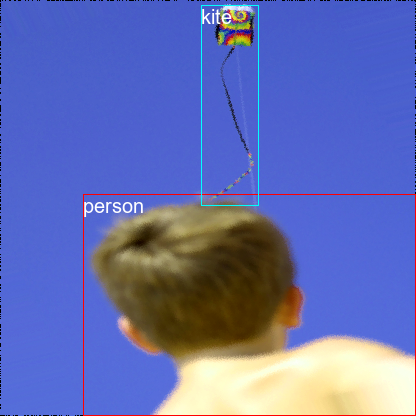

In [66]:
draw_bbox_class(trans.ToPILImage()(de_preprocess(conf,imgs[0].cpu())),labels_group[0].cpu(),bboxes_group[0].cpu(),correct_id_2_class)

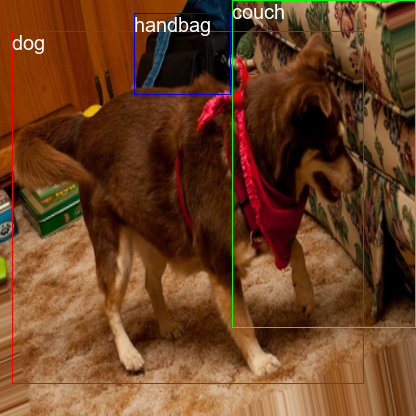

In [76]:
show_util(conf,10,imgs,labels_group,bboxes_group,correct_id_2_class)

In [77]:
nn.BCEWithLogitsLoss(
            weight=conf_weight[l], size_average=False)(loss_feats[l][..., 4],
                                                       targets[l][..., 4])

tensor(8850.3154, device='cuda:0')

In [85]:
l = 0

In [88]:
targets[l][...,-1][gt_mask[l] == 1].to(torch.long)

tensor([  0,  20,   0,   0,  60,   0,   7,  56,   0,  24,   0,  60,
          0,   0,   0,  51,  50,  43,  19,  26,  57,  16,  73,  73,
         73,  59,  26,  73,  59,   0,   2,  36,   0,   0], device='cuda:0')

In [93]:
loss_feats[l][...,5:][gt_mask[l] == 1]

torch.Size([34, 80])

In [94]:
nn.CrossEntropyLoss(size_average=False)(
            loss_feats[l][..., 5:][gt_mask[l] == 1],
            targets[l][..., -1][gt_mask[l] == 1].to(torch.long))

tensor(154.0689, device='cuda:0')

In [95]:
conf.coord_scale

2.0

In [96]:
conf.class_scale

5.0

In [98]:
nB = len(loss_feats[l])

In [99]:
conf.class_scale * nn.CrossEntropyLoss(size_average=False)(
            loss_feats[l][..., 5:][gt_mask[l] == 1],
            targets[l][..., -1][gt_mask[l] == 1].to(torch.long)) / nB

tensor(51.3563, device='cuda:0')

In [101]:
losses = namedtuple('losses',['loss_total','loss_xy','loss_wh','loss_conf','loss_cls'])

In [102]:
def yolo_loss(conf,loss_feats, targets, gt_mask, conf_weight, coord_mask):
    loss_xy = 0
    loss_wh = 0
    loss_conf = 0
    loss_cls = 0
    losses = namedtuple('losses',['loss_total','loss_xy','loss_wh','loss_conf','loss_cls'])
    for l in range(3):
        nB = len(loss_feats[l])
        loss_xy += conf.coord_scale * conf.bce_loss(loss_feats[l][coord_mask[l] == 1][..., :2],
                                 targets[l][coord_mask[l] == 1][..., :2]) / nB
        loss_wh += conf.coord_scale * conf.mse_loss(loss_feats[l][coord_mask[l] == 1][..., 2:4],
                                 targets[l][coord_mask[l] == 1][..., 2:4]) / nB
        loss_conf += nn.BCEWithLogitsLoss(
            weight=conf_weight[l], size_average=False)(loss_feats[l][..., 4],
                                                       targets[l][..., 4]) / (2 * nB)
        loss_cls += conf.class_scale * nn.CrossEntropyLoss(size_average=False)(
            loss_feats[l][..., 5:][gt_mask[l] == 1],
            targets[l][..., -1][gt_mask[l] == 1].to(torch.long)) / nB
    loss_total = loss_xy + loss_wh + loss_conf + loss_cls
    
    return losses(loss_total,loss_xy.item(),loss_wh.item(),loss_conf.item(),loss_cls.item())

In [103]:
yolo_loss(conf,loss_feats,targets,gt_mask,conf_weight,coord_mask)

losses(loss_total=tensor(2207.0342, device='cuda:0'), loss_xy=20.214155197143555, loss_wh=9.04418659210205, loss_conf=2020.8790283203125, loss_cls=156.89674377441406)